In [1]:
from sympy import init_printing, latex
import numpy as np
import copy
import matplotlib.pyplot as plt
init_printing(latex_printer=lambda *args, **kwargs: latex(*args, mul_symbol='dot', **kwargs))

# 1 Single Concentration versus Time Model

Key             Label                          Data      
SC              Surface Coverage               1         
r               Rate of Association            2         
P_capacity      Cell Capacity                  3         
S               Surface Area                   2         
V               Volume                         1         


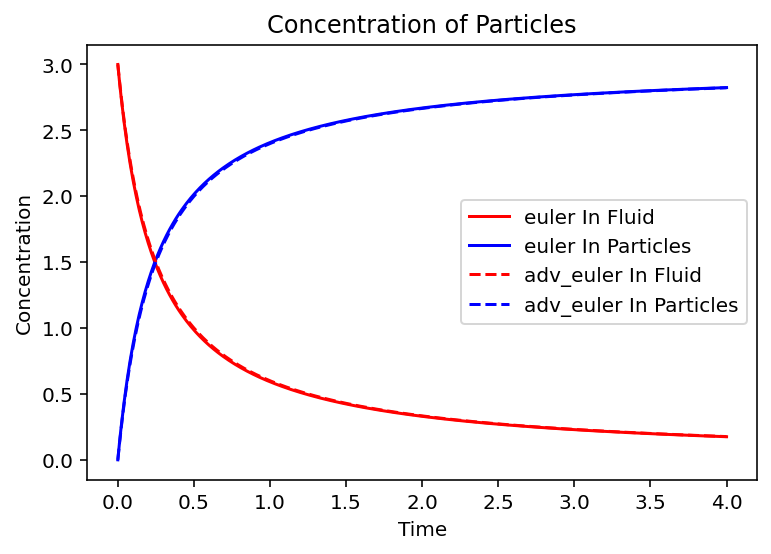

Cell Concentration p : 2.82352143019305


In [2]:


class ODE_Concentration:
    """Solve ODE using numerical iterations"""
    def __init__(self, STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params):
        self.STEP_SIZE = STEP_SIZE
        self.TARGET_TIME = TARGET_TIME
        self.INIT_U = INIT_U
        self.INIT_P = INIT_P
        self.params = params
        self.solve()

    ## Define Functions
    def f_cell_CCC(self, SC, r, P_capacity, p, u):
        return SC * r * (P_capacity-p)/P_capacity*u

    def du(self, S,V,f_cell):
        return -(S/V) * f_cell

    def dp(self, S,V,f_cell):
        return +(S/V) * f_cell

    def solve(self):
        ## Assign Values
        h = self.STEP_SIZE
        t = np.arange(0, self.TARGET_TIME+h, h)
        u = np.zeros(t.shape)
        p = np.zeros(t.shape)
        adv_u = np.zeros(t.shape)
        adv_p = np.zeros(t.shape)
        u[0] = self.INIT_U
        p[0] = self.INIT_P
        adv_u[0] = self.INIT_U
        adv_p[0] = self.INIT_P
        SC = self.params["SC"][1]
        r = self.params["r"][1]
        P_capacity = self.params["P_capacity"][1]
        S = self.params["S"][1]
        V = self.params["V"][1]

        ## Iterate and update
        for i in range( len(t) - 1 ):
            ## Normal Euler Method:  predict [NEXT point] using [CURRENT derivative]
            # Update U
            u[i+1] = u[i] + h * self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))
            # Update P
            p[i+1] = p[i] + h * self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))

            ## Advanced Euler Method: predict [NEXT point] using [CURRENT derrivarive]&[NEXT point's derivative]
            cur_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))
            cur_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))

            pred_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))
            pred_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))

            adv_u[i+1] = adv_u[i] + (h/2) * (cur_du + pred_du)
            adv_p[i+1] = adv_p[i] + (h/2) * (cur_dp + pred_dp)
        self.adv_u = adv_u
        self.adv_p = adv_p
        self.p = p
        self.u = u
        self.t = t

    def get_params(self):
        print("{:<15} {:<30} {:<10}".format('Key','Label','Data'))
        for k, v in self.params.items():
            label, data = v
            print("{:<15} {:<30} {:<10}".format(k, label, data))

    ## Plotting
    def plot_integral(self):
        self.get_params()
        fig = plt.figure(dpi = 144)
        ax = fig.gca()
        ax.plot(self.t, self.u, 'r-', label="euler In Fluid")
        ax.plot(self.t, self.p, 'b-', label="euler In Particles")
        ax.plot(self.t, self.adv_u, 'r--', label="adv_euler In Fluid")
        ax.plot(self.t, self.adv_p, 'b--', label="adv_euler In Particles")
        ax.set_ylabel("Concentration")
        ax.set_xlabel("Time")
        ax.set_title("Concentration of Particles")
        ax.legend(loc='center right')
        # plt.savefig("./1.jpg")
        plt.show()
        

    def get_fluid_concentration(self):
        return self.adv_u[-1]

    def get_cell_concentration(self):
        return self.adv_p[-1]

## Define Values
STEP_SIZE = 0.01
TARGET_TIME = 4
INIT_U = 3
INIT_P = 0
params = {   # Symbol + Description + Data
            "SC":["Surface Coverage", 1],
            "r":["Rate of Association", 2],
            "P_capacity":["Cell Capacity", 3],
            "S":["Surface Area", 2],
            "V":["Volume", 1],
        }

ode = ODE_Concentration(STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params)
ode.plot_integral()
print("Cell Concentration p :", ode.get_cell_concentration())


## 2 Liver-Particle Association Model

### 2.1 Define Data Stucture

In [3]:
  ## Define Stuctures
class Particle:
    def __init__(self, Ctype, size):
        self.type = Ctype
        self.size = size
        
    def get_type(self):
        print(self.Ctype)

class Cell:
    def __init__(self, r_in, r_out, max_capacity, init_concentration, surface_coverage, fenestrae_size=1):
        self.r_in = r_in
        self.r_out = r_out
        self.capacity = max_capacity
        self.concentration = init_concentration
        self.u = []
        self.SC = surface_coverage
        self.fenestrae_size=fenestrae_size

class Fluid:
    def __init__(self, r, init_concentration):
        self.r = r
        self.concentration = init_concentration
        self.u = []

### 2.2 Define ODE Class

In [4]:


class ODE_Liver_Particle:
    """Solve ODE using numerical iterations"""
    def __init__(self, STEP_SIZE, TARGET_TIME, Particle, Blood, Kupffer, Endothelial, Space, Hepatocytes, BileDuct, particle_data, fluid_data, cell_data):
        self.P = Particle
        self.STEP_SIZE = STEP_SIZE
        self.TARGET_TIME = TARGET_TIME
        self.Particle = Particle
        self.Blood = Blood
        self.Kupffer = Kupffer
        self.Endothelial = Endothelial
        self.Space = Space
        self.Hepatocytes = Hepatocytes
        self.BileDuct = BileDuct
        self.particle_data = particle_data
        self.fluid_data = fluid_data
        self.cell_data = cell_data


    ## Define General Functions, refering to different biological math model regarding each different situation

    def f_f2c(self, Fluid, Cell):
        """Fluid to Cell Generalised Function"""
        return Cell.SC * Cell.r_in * ((Cell.capacity - Cell.concentration)/Cell.capacity) * Fluid.concentration

    def f_c2f(self, Cell, Fluid):
        """Cell to Fluid Generalised Function"""
        return Cell.SC * Cell.r_out * Cell.concentration

    def f_f2f(self, FluidA, FluidB, fenestrae_size):
        """FluidA to FluidB Generalised Function"""
        return FluidA.r * FluidB.r * (fenestrae_size/self.P.size) * FluidA.concentration

    # Differential Equation, refering to the change of number of particles in each part = rate in - rate out
    def dBlood(self):
        return self.f_c2f(self.Kupffer, self.Blood) - self.f_f2c(self.Blood, self.Kupffer)\
                + self.f_c2f(self.Endothelial, self.Blood) - self.f_f2c(self.Blood, self.Endothelial)\
                + self.f_f2f(self.Space, self.Blood, self.Endothelial.fenestrae_size) - self.f_f2f(self.Blood, self.Space, self.Endothelial.fenestrae_size)

    def dKupffer(self):
        return self.f_f2c(self.Blood, self.Kupffer) - self.f_c2f(self.Kupffer, self.Blood)

    def dEndothelial(self):
        return self.f_f2c(self.Blood, self.Endothelial) - self.f_c2f(self.Endothelial, self.Blood)\
            + self.f_f2c(self.Space, self.Endothelial) - self.f_c2f(self.Endothelial, self.Space)
    
    def dSpace(self):
        return self.f_f2f(self.Blood, self.Space, self.Endothelial.fenestrae_size) - self.f_f2f(self.Space, self.Blood, self.Endothelial.fenestrae_size)\
             + self.f_c2f(self.Endothelial, self.Space) - self.f_f2c(self.Space, self.Endothelial)\
                 -self.f_f2c(self.Space, self.Hepatocytes)

    def dHepatocytes(self):
        return self.f_f2c(self.Space, self.Hepatocytes)\
            - self.f_c2f(self.Hepatocytes, self.BileDuct)

    def dBileDuct(self):
        return self.f_c2f(self.Hepatocytes, self.BileDuct)


    def set_init(self, t):
        """Set Initial Value and initialize array for use"""
        # Initialise array
        for obj in [self.Blood, self.Kupffer, self.Endothelial, self.Space, self.Hepatocytes, self.BileDuct]:
            obj.u = np.zeros(t.shape)
            obj.u[0] = obj.concentration

    def update_concentration(self, i):
        """update the Concentration to newest data"""
        for obj in [self.Blood, self.Kupffer, self.Endothelial, self.Space, self.Hepatocytes, self.BileDuct]:
            obj.concentration = obj.u[i]

    def solve(self):
        """Solve the ODE with given conditions"""
        ## Assign Values and set initial value
        h = self.STEP_SIZE
        self.t = np.arange(0, self.TARGET_TIME+h, h)
        self.set_init(self.t)
        ## Iterate and update
        for i in range( len(self.t) - 1 ):
            ## Normal Euler Method:  predict [NEXT point] using [CURRENT derivative]
            self.Blood.u[i+1] = self.Blood.u[i] + h * self.dBlood()
            self.Kupffer.u[i+1] = self.Kupffer.u[i] + h * self.dKupffer()
            self.Endothelial.u[i+1] = self.Endothelial.u[i] + h * self.dEndothelial()
            self.Space.u[i+1] = self.Space.u[i] + h * self.dSpace()
            self.Hepatocytes.u[i+1] = self.Hepatocytes.u[i] + h * self.dHepatocytes()
            self.BileDuct.u[i+1] = self.BileDuct.u[i] + h * self.dBileDuct()
            # For each loop, update the cooresponding concentration
            self.update_concentration(i)
            ## Update Concentration to newest ones.
            ## Advanced Euler Method: predict [NEXT point] using [CURRENT derrivarive]&[NEXT point's derivative]
            # Skipped, as the results should roughly be the same if the step size is small enough

    def get_params(self):
        """print out the parameters for each data"""
        print("===============Particle Data===============")
        print("{:<15} {:<30} {:<10}".format('Particle','Type','Size'))
        for k, v in self.particle_data.items():
            Ctype, data = v.values()
            print("{:<15} {:<30} {:<10}".format(k, Ctype, data))
        print("===============Fluid Data===============")
        print("{:<15} {:<30} {:<10}".format('Fluid','r_assoc','init_concentration'))
        for k, v in self.fluid_data.items():
            r_assoc, init_u = v.values()
            print("{:<15} {:<30} {:<10}".format(k, r_assoc, init_u))
        print("==================Cell Data==================")
        print("{:<15} {:<10} {:<10} {:<10} {:<20} {:<20} {:<20}".format('Cell','r_in','r_out','max_cap','init_concentration', 'Surface_Coverage', 'Fenestrae_Size'))
        for k, v in self.cell_data.items():
            a,b,c,d,e,f = v.values()
            print("{:<15} {:<10} {:<10} {:<10} {:<20} {:<20} {:<20}".format(k,a,b,c,d,e,f))
        
    ## Plotting
    def plot_integral(self, show_data=True, Title="Concentration of Particles"):
        """Plot the concentration of fluid/cell overall"""
        if show_data: self.get_params()
        fig = plt.figure(dpi = 144)
        ax = fig.gca()
        ax.plot(self.t, [self.BileDuct.concentration]*len(self.Blood.u), 'k--')
        ax.plot(self.t, self.Blood.u, 'r-', label="Blood")
        ax.plot(self.t, self.Kupffer.u, 'g-', label="Kupffer")
        ax.plot(self.t, self.Endothelial.u, 'b-', label="Endothelial")
        ax.plot(self.t, self.Space.u, 'y-', label="Space")
        ax.plot(self.t, self.Hepatocytes.u, 'c-', label="Hepatocytes")
        ax.plot(self.t, self.BileDuct.u, 'm-', label="BileDuct")
        ax.set_ylabel("Concentration")
        ax.set_xlabel("Time")
        ax.set_title(Title)
        ax.legend(loc='center right')
        # plt.savefig("./1.jpg")
        plt.show()

    def get_concentration(self, Struct):
        """return the concentration after the last time update of particular cell or fluid"""
        return Struct.u[-1]


### 2.3 Solve With Data

===============Particle Data===============
Particle        Type                           Size      
Test_Particle   Non-Biodegradable              2         
===============Fluid Data===============
Fluid           r_assoc                        init_concentration
Blood           1                              1         
Space           1                              0         
BileDuct        1                              0         
==================Cell Data==================
Cell            r_in       r_out      max_cap    init_concentration   Surface_Coverage     Fenestrae_Size      
Kupffer         1          1          1          0                    1                    1                   
Endothelial     1          1          1          0                    1                    1                   
Hepatocytes     1          1          1          0                    1                    1                   


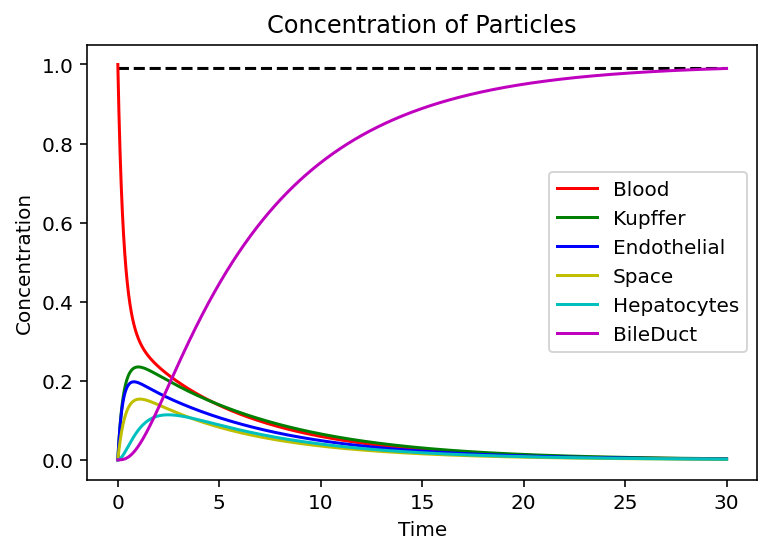

Concentration p of BileDuct: 0.9899571746191719


In [5]:
## Define Values
STEP_SIZE = 0.001
TARGET_TIME = 30

## data set up
particle_data = {
    "Test_Particle":{
        "Particle_Type": "Non-Biodegradable",
        "ParticleSize": 2,
    }
}

fluid_data = {
    "Blood":{
        "rate_association": 1,
        "init_concentration":1,
    },
    "Space":{
        "rate_association": 1,
        "init_concentration":0,
    },
    "BileDuct":{
        "rate_association": 1,
        "init_concentration":0,
    },
}
cell_data = {
    "Kupffer":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Endothelial":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Hepatocytes":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
}

#### Initialize Types
def Initialize_ODE(particle_data, fluid_data, cell_data):
    """Initialize the ODE function with given data, call ode.solve() to solve it later"""
    #Particle
    Par = Particle(particle_data["Test_Particle"]["Particle_Type"], particle_data["Test_Particle"]["ParticleSize"])
    #Fluid
    Blood = Fluid(fluid_data["Blood"]["rate_association"], fluid_data["Blood"]["init_concentration"])
    Space = Fluid(fluid_data["Space"]["rate_association"], fluid_data["Space"]["init_concentration"])
    BileDuct = Fluid(fluid_data["BileDuct"]["rate_association"], fluid_data["BileDuct"]["init_concentration"])
    #Cell
    Kupffer = Cell(cell_data["Kupffer"]["rate_in"], cell_data["Kupffer"]["rate_out"], cell_data["Kupffer"]["max_capacity"], cell_data["Kupffer"]["initial_concentration"], cell_data["Hepatocytes"]["surface_coverage"])
    Endothelial = Cell(cell_data["Endothelial"]["rate_in"], cell_data["Endothelial"]["rate_out"], cell_data["Endothelial"]["max_capacity"], cell_data["Endothelial"]["initial_concentration"], cell_data["Endothelial"]["surface_coverage"], cell_data["Endothelial"]["fenestrae_size"])
    Hepatocytes = Cell(cell_data["Hepatocytes"]["rate_in"], cell_data["Hepatocytes"]["rate_out"], cell_data["Hepatocytes"]["max_capacity"], cell_data["Hepatocytes"]["initial_concentration"], cell_data["Hepatocytes"]["surface_coverage"])
    ### Call Function
    return ODE_Liver_Particle(STEP_SIZE, TARGET_TIME, Par, Blood, Kupffer, Endothelial, Space, Hepatocytes, BileDuct, particle_data, fluid_data, cell_data)

    
ode = Initialize_ODE(particle_data, fluid_data, cell_data)
ode.solve()
ode.plot_integral()
print("Concentration p of BileDuct:", ode.get_concentration(ode.BileDuct))

In [6]:
def compare_ode_models(ode_list, names, time_range):
    start_t, end_t = time_range
    """This Function takes a list of ODE models and plot each factors to compare across different models"""
    ## Check if the time range is valid
    if (ode_list[0].t[-1] < end_t) or (ode_list[0].t[0]>start_t):
        print("Time Range is outside of the Model's Time range, Please Try Again")
        return 0
    ## Get index of the corrected time range
    def condition(x): 
        return (x < end_t) and (x>start_t)
    fig, axs = plt.subplots(2, 3, figsize=(15,8), dpi=100, sharex=True,sharey=True)
    #rgb=["r-", "r--", "y-", "k-", "m-"]
    style=["-", "--", "-.", ":"]
    for ode in ode_list:
        
        #c=rgb.pop(0)
        s = style.pop(0)
        j = [idx for idx, element in enumerate(ode.t) if condition(element)]
        axs[0, 1].plot(ode.t[j], ode.Blood.u[j], 'r'+s, label="Blood")
        axs[1, 0].plot(ode.t[j], ode.Kupffer.u[j], 'g'+s, label="Kupffer")
        axs[1, 1].plot(ode.t[j], ode.Endothelial.u[j], 'b'+s, label="Endothelial")
        axs[0, 2].plot(ode.t[j], ode.Space.u[j], 'y'+s, label="Space")
        axs[1, 2].plot(ode.t[j], ode.Hepatocytes.u[j], 'c'+s, label="Hepatocytes")
        axs[0, 0].plot(ode.t[j], ode.BileDuct.u[j], 'm'+s, label="BileDuct")
        

    axs[0, 0].set_title('BileDuct')
    axs[0, 1].set_title('Blood')
    axs[1, 0].set_title('Kupffer')
    axs[1, 1].set_title('Endothelial')
    axs[0, 2].set_title('Space')
    axs[1, 2].set_title('Hepatocytes')
    fig.legend(names,loc='center right')
    
    for ax in axs.flat:
        ax.sharey(axs[0, 0])
    fig.text(0.5, 0.05, 'Time', ha='center')
    fig.text(0.08, 0.5, 'Concentration', va='center', rotation='vertical')
    plt.show()
    k=0
    for ode in ode_list: 
        ode.plot_integral(show_data=False, Title=names[k])
        k+=1



# 3 Testing by manipulating parameters

## 3.1 Remove Kupffer's Effect on Association

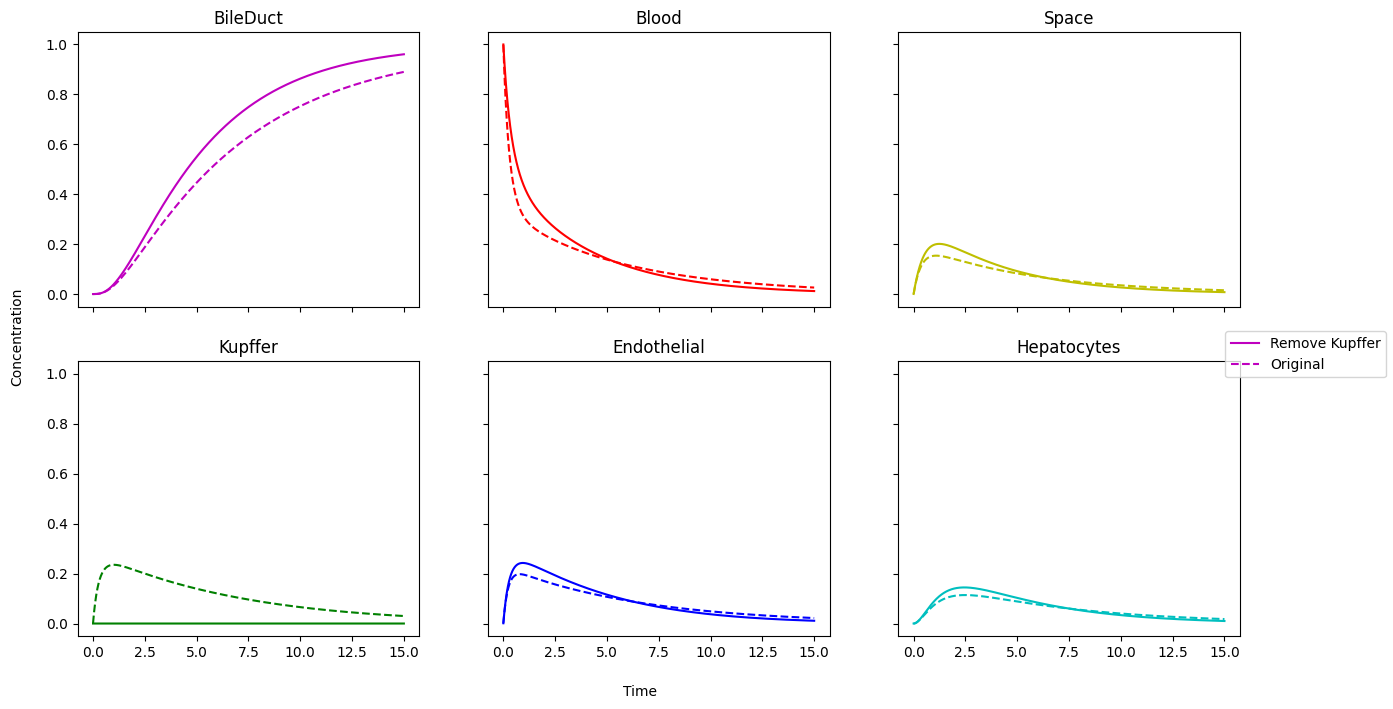

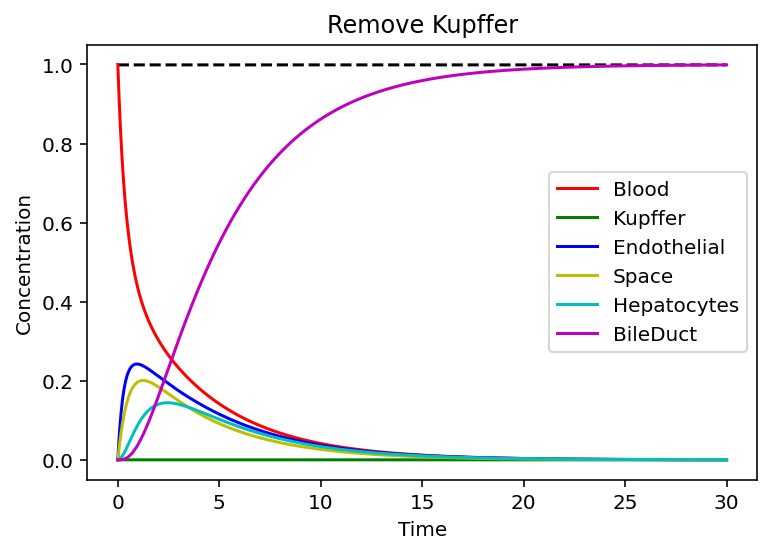

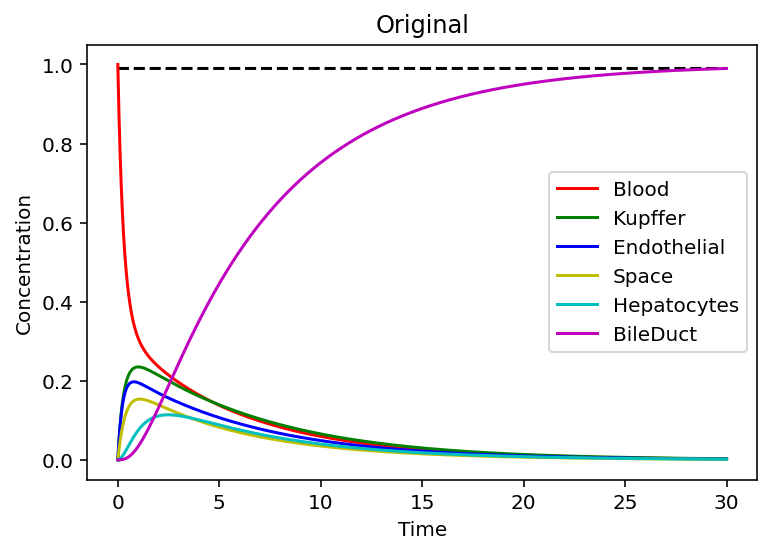

In [7]:

## Remove Kupffer's effect by setting it no absorb and out
TARGET_TIME = 30
remove_kup_data = copy.deepcopy(cell_data)
remove_kup_data["Kupffer"]["rate_in"] = remove_kup_data["Kupffer"]["rate_out"] = 0

## Without Kupffer Cell's OverView
ode = Initialize_ODE(particle_data, fluid_data, cell_data)
ode.solve()
ode_noKupffer = Initialize_ODE(particle_data, fluid_data, remove_kup_data)
ode_noKupffer.solve()

ode_list = [ode_noKupffer, ode]
ode_names = ["Remove Kupffer", "Original"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

### 3.2 Particle Size 

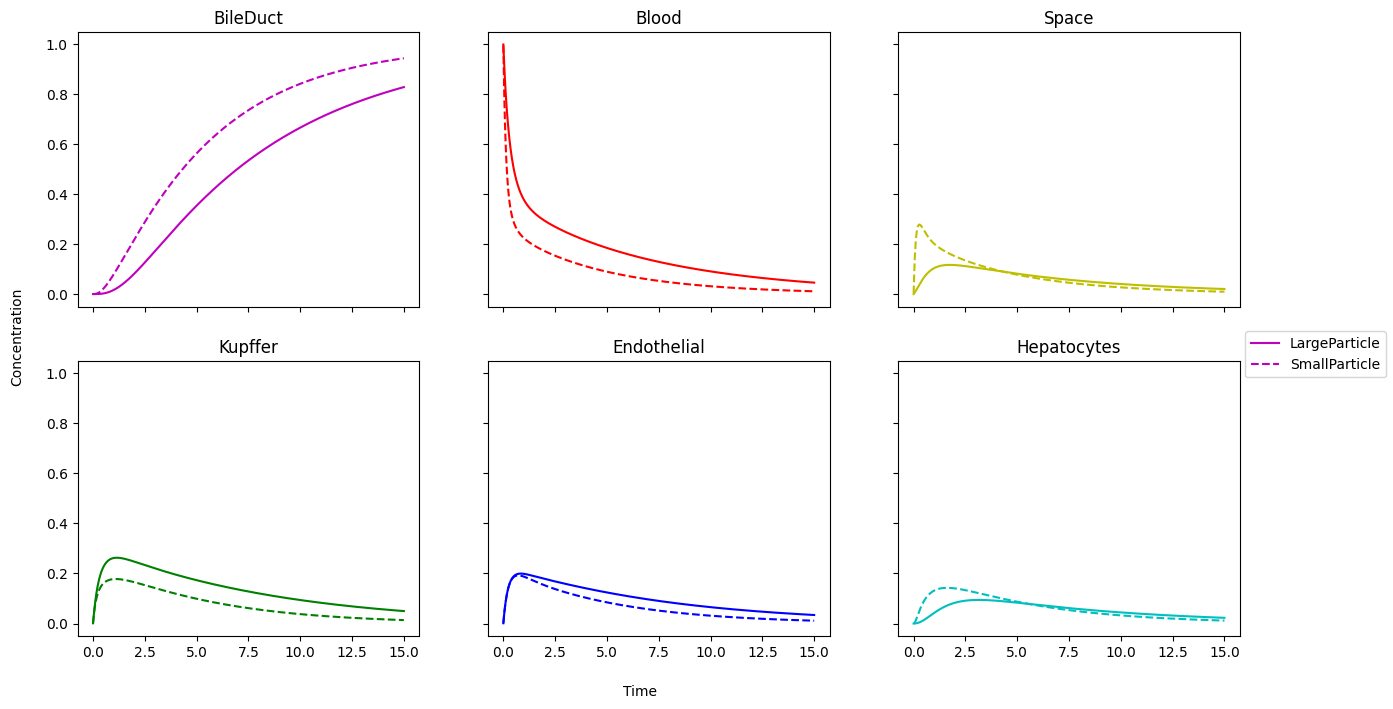

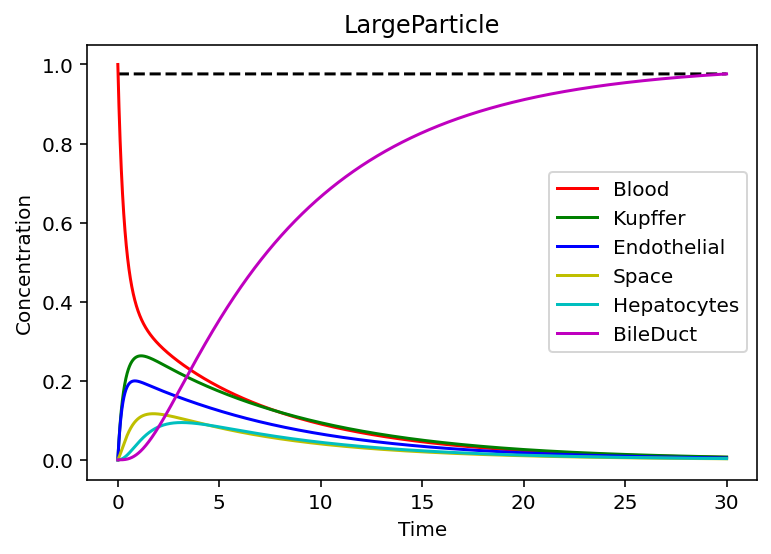

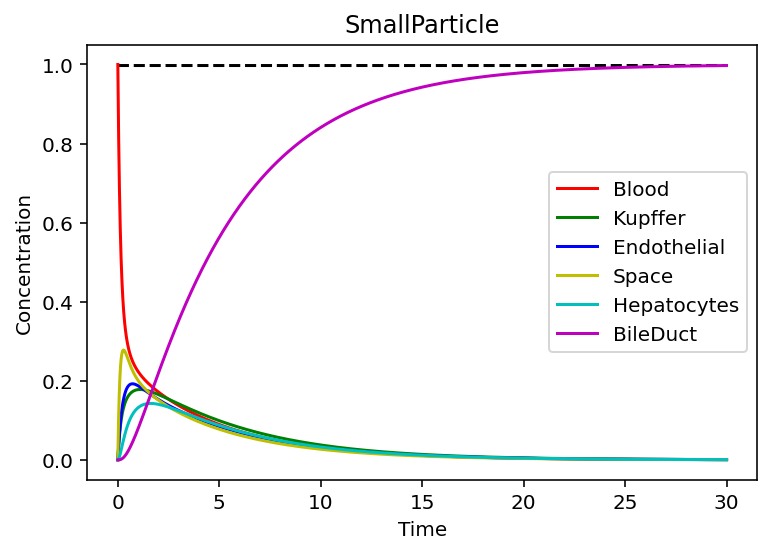

In [8]:

## Change the Particle Sizes
TARGET_TIME = 30
Large_P_data = copy.deepcopy(particle_data)
Large_P_data["Test_Particle"] = {
        "Particle_Type": "Non-Bio-Large",
        "ParticleSize": 10,
    }
## With Large Particle's OverView
ode_LargeP = Initialize_ODE(Large_P_data, fluid_data, cell_data)
ode_LargeP.solve()

Small_P_data = copy.deepcopy(particle_data)
Small_P_data["Test_Particle"] = {
        "Particle_Type": "Non-Bio-Large",
        "ParticleSize": 0.3,
    }
## With Smaller Particle's OverView
ode_SmallP = Initialize_ODE(Small_P_data, fluid_data, cell_data)
ode_SmallP.solve()


ode_list = [ode_LargeP, ode_SmallP]
ode_names = ["LargeParticle", "SmallParticle"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

### 3.3 Hepatocutes Reach Max_Capacity

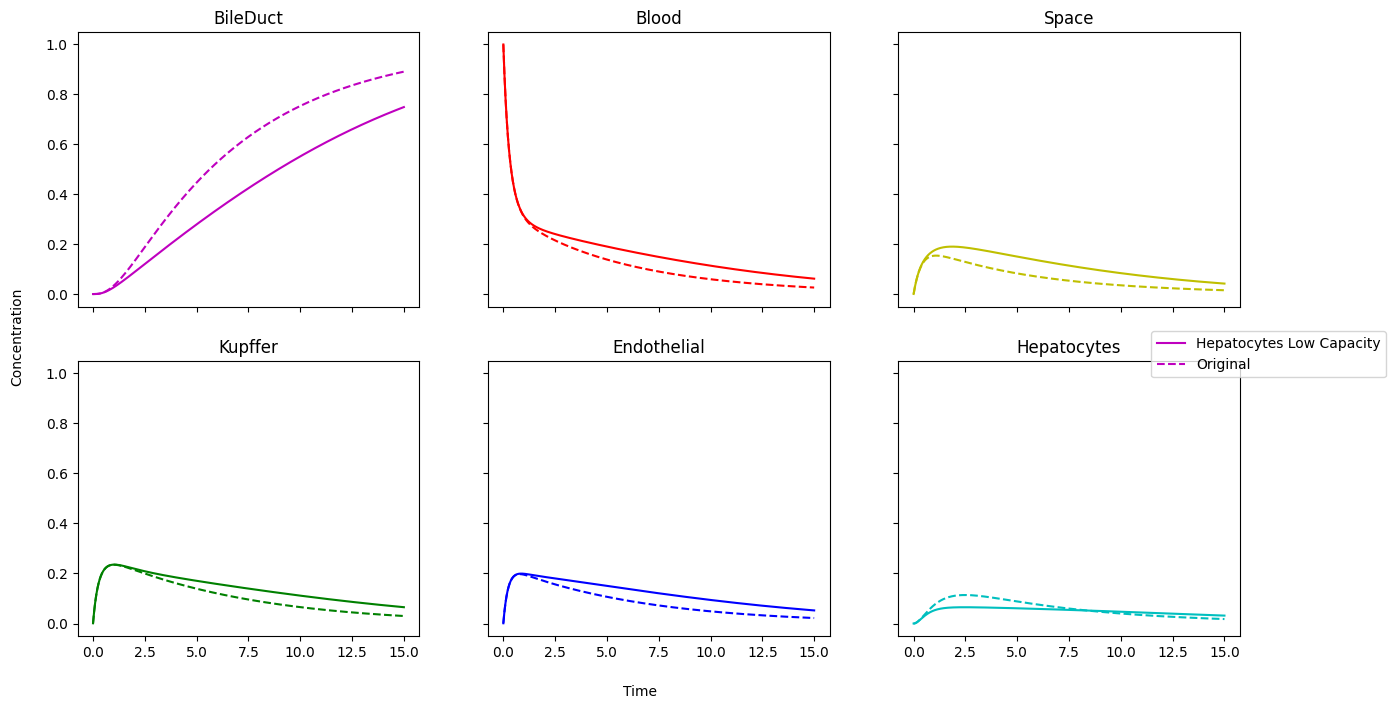

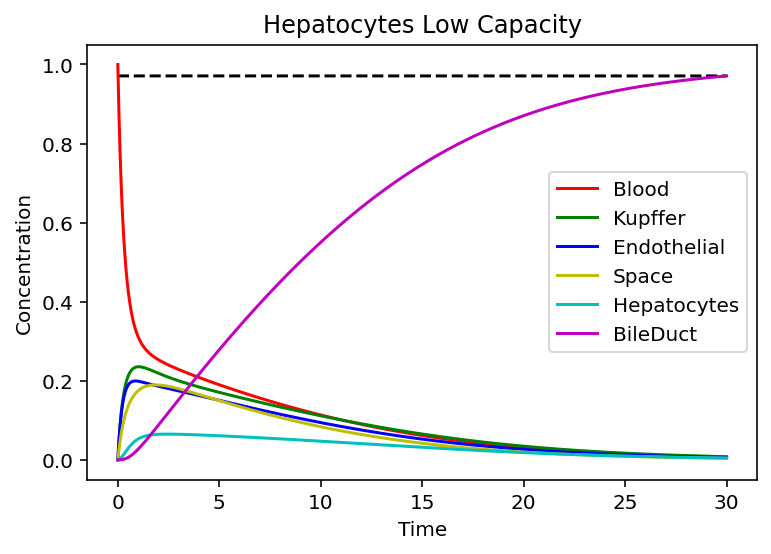

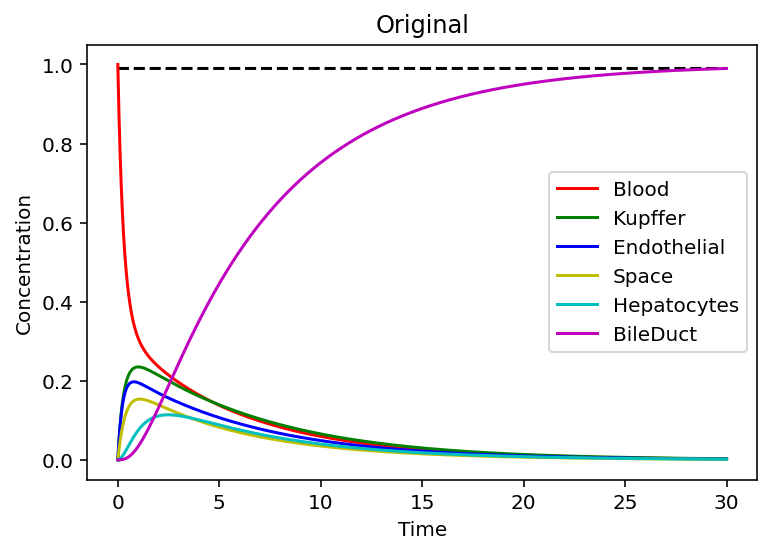

In [9]:
TARGET_TIME = 30
new_hepa_data = copy.deepcopy(cell_data)
new_hepa_data["Hepatocytes"]["max_capacity"] = 0.1

## Without Kupffer Cell's OverView
ode = Initialize_ODE(particle_data, fluid_data, cell_data)
ode.solve()
ode_newHepa = Initialize_ODE(particle_data, fluid_data, new_hepa_data)
ode_newHepa.solve()

ode_list = [ode_newHepa, ode]
ode_names = ["Hepatocytes Low Capacity", "Original"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

### 3.4 What if body Fluid is "Sticky"?

In [32]:
## Define Values
STEP_SIZE = 0.001
TARGET_TIME = 30

## data set up
particle_data = {
    "Test_Particle":{
        "Particle_Type": "Non-Biodegradable",
        "ParticleSize": 2,
    }
}

fluid_data = {
    "Blood":{
        "rate_association": 0.01,
        "init_concentration":1,
    },
    "Space":{
        "rate_association": 0.05,
        "init_concentration":0,
    },
    "BileDuct":{
        "rate_association": 0.05,
        "init_concentration":0,
    },
}
cell_data = {
    "Kupffer":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Endothelial":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Hepatocytes":{
        "rate_in":1,
        "rate_out":1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
}

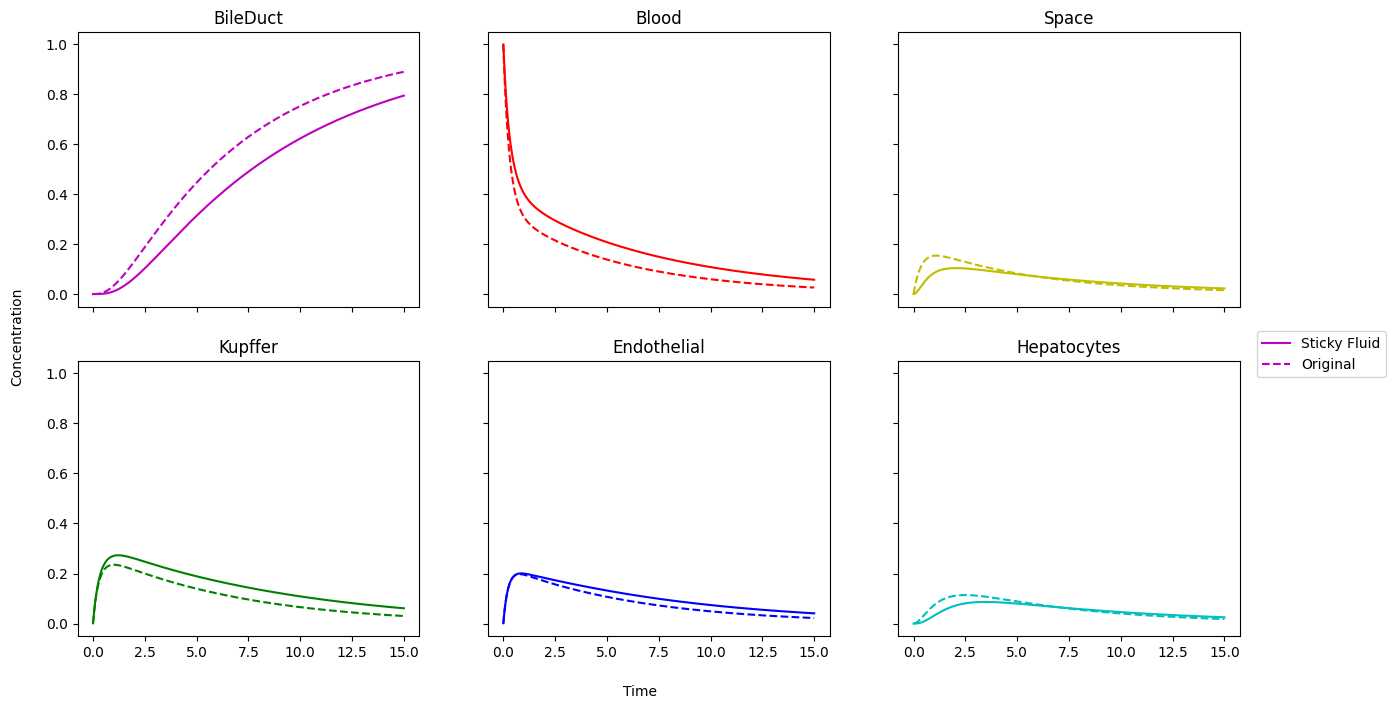

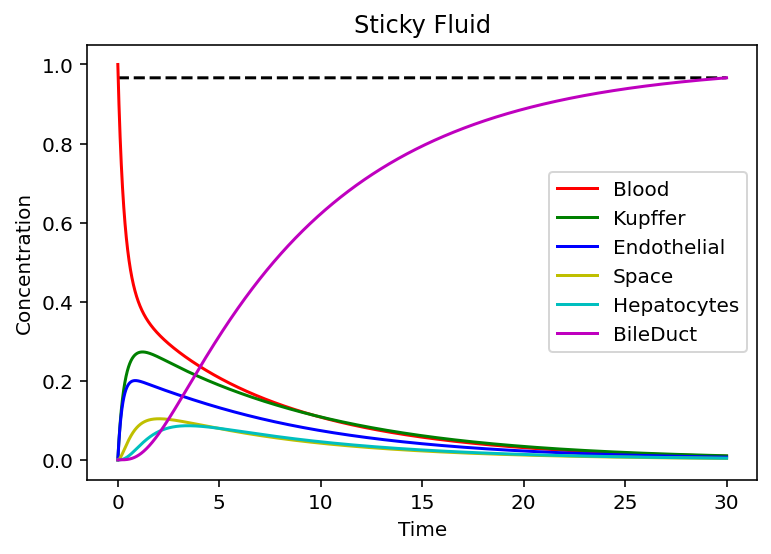

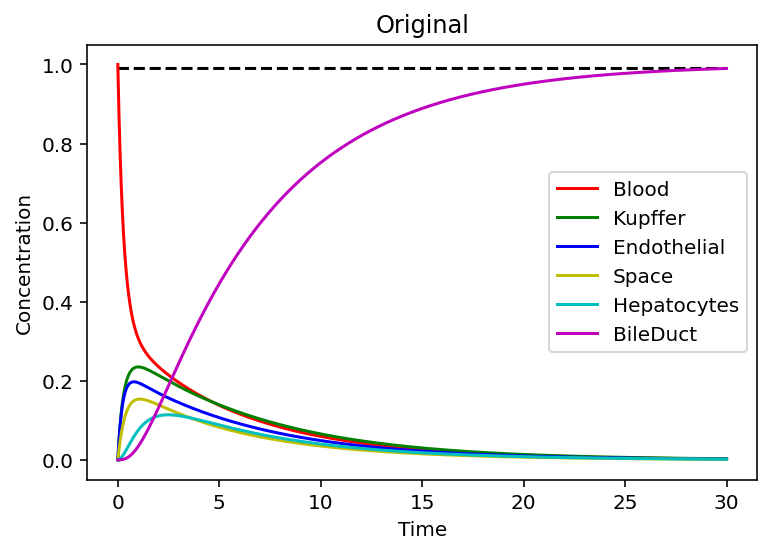

In [33]:
TARGET_TIME = 30

## With Body Fluid more Sticky
ode_Sticky_Fluid = Initialize_ODE(particle_data, fluid_data, cell_data)
ode_Sticky_Fluid.solve()

ode_list = [ode_Sticky_Fluid, ode]
ode_names = ["Sticky Fluid", "Original"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

When making body fluid more sticky (with less particle random movement rate), it appears to directly affect the particle transmissions through the fenestrae. As the graph suggested, fenestrae transmission takes an important role in particle association as there's significant change of concentration in BileDuct.

Similarly, by decreasing the fenestrae size, it would have similar effect as those two directly affect fenestrae transmission only in our model. 

[Be aware that the fenestrae size changes may lead to change in Surface Coverage SC parameter]
Discussed Above: 
- Assume Surface_Coverage is not affected by Fenestrae_Size

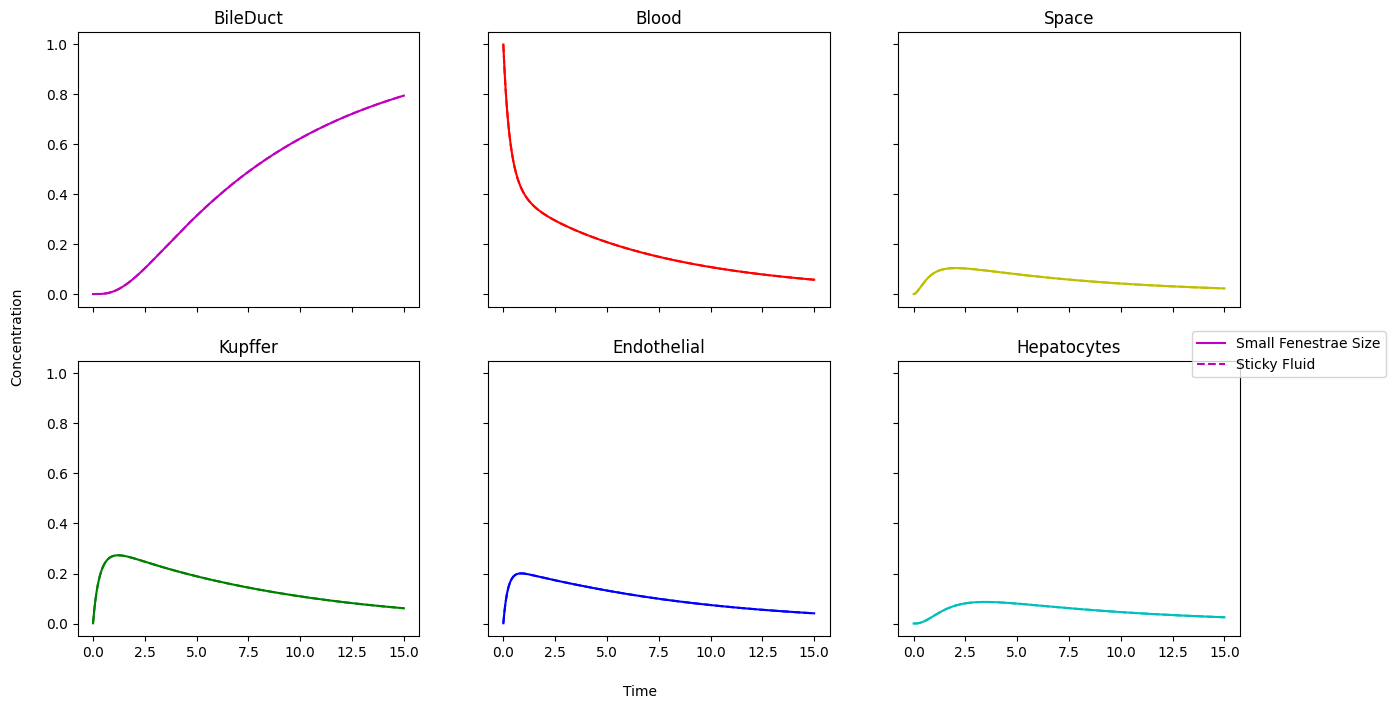

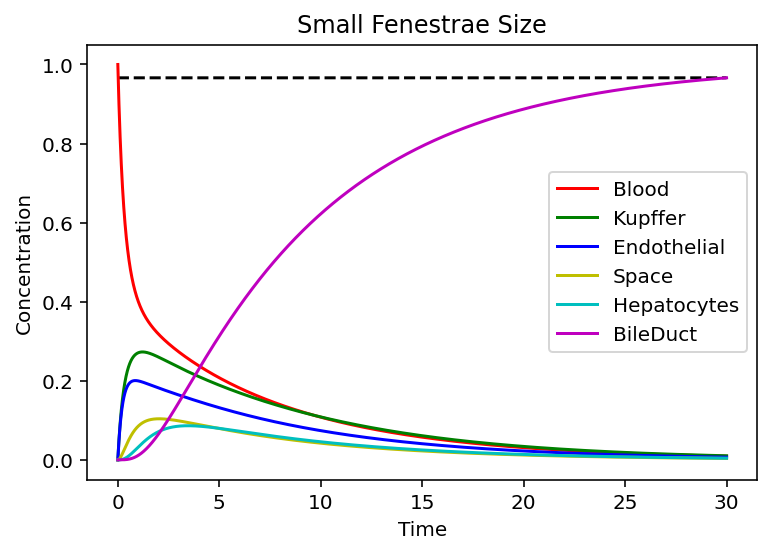

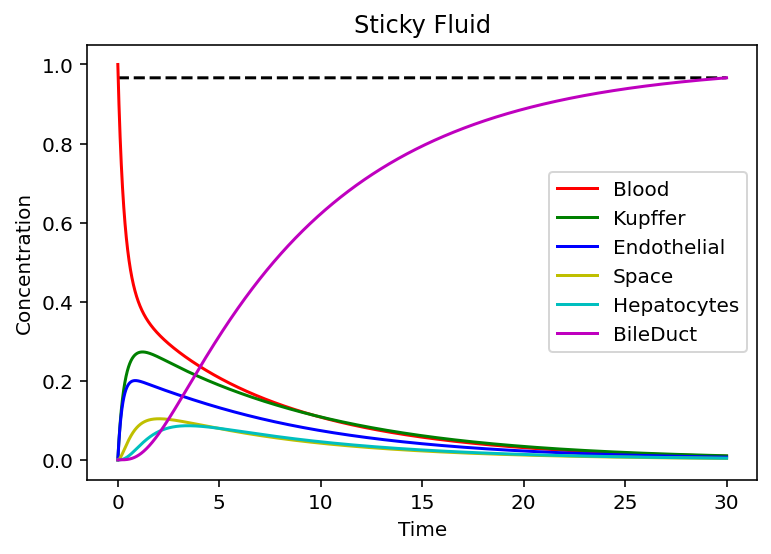

In [40]:
TARGET_TIME = 30
Small_fenestrae_cell_data = copy.deepcopy(cell_data)
Small_fenestrae_cell_data["Endothelial"]["fenestrae_size"] = 0.1
Small_fenestrae_cell_data["Endothelial"]["surface_coverage"] = 1

ode_fenestrae = Initialize_ODE(particle_data, fluid_data, Small_fenestrae_cell_data)
ode_fenestrae.solve()

ode_list = [ode_fenestrae, ode_Sticky_Fluid]
ode_names = ["Small Fenestrae Size",  "Sticky Fluid"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

Interestingly, if the fluid is very very sticky, the fenestrae size doesn't affect the overall rate very much since fluid rate dominates the association rate between fluid

### 3.4 What if Cells are Less Active?

In [12]:
## Define Values
STEP_SIZE = 0.001
TARGET_TIME = 30

## data set up
particle_data = {
    "Test_Particle":{
        "Particle_Type": "Non-Biodegradable",
        "ParticleSize": 2,
    }
}

fluid_data = {
    "Blood":{
        "rate_association": 1,
        "init_concentration":1,
    },
    "Space":{
        "rate_association": 1,
        "init_concentration":0,
    },
    "BileDuct":{
        "rate_association": 1,
        "init_concentration":0,
    },
}
cell_data = {
    "Kupffer":{
        "rate_in":0.1,
        "rate_out":0.1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Endothelial":{
        "rate_in":0.1,
        "rate_out":0.1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
    "Hepatocytes":{
        "rate_in":0.1,
        "rate_out":0.1,
        "max_capacity":1,
        "initial_concentration":0,
        "surface_coverage": 1,
        "fenestrae_size":1,
    },
}

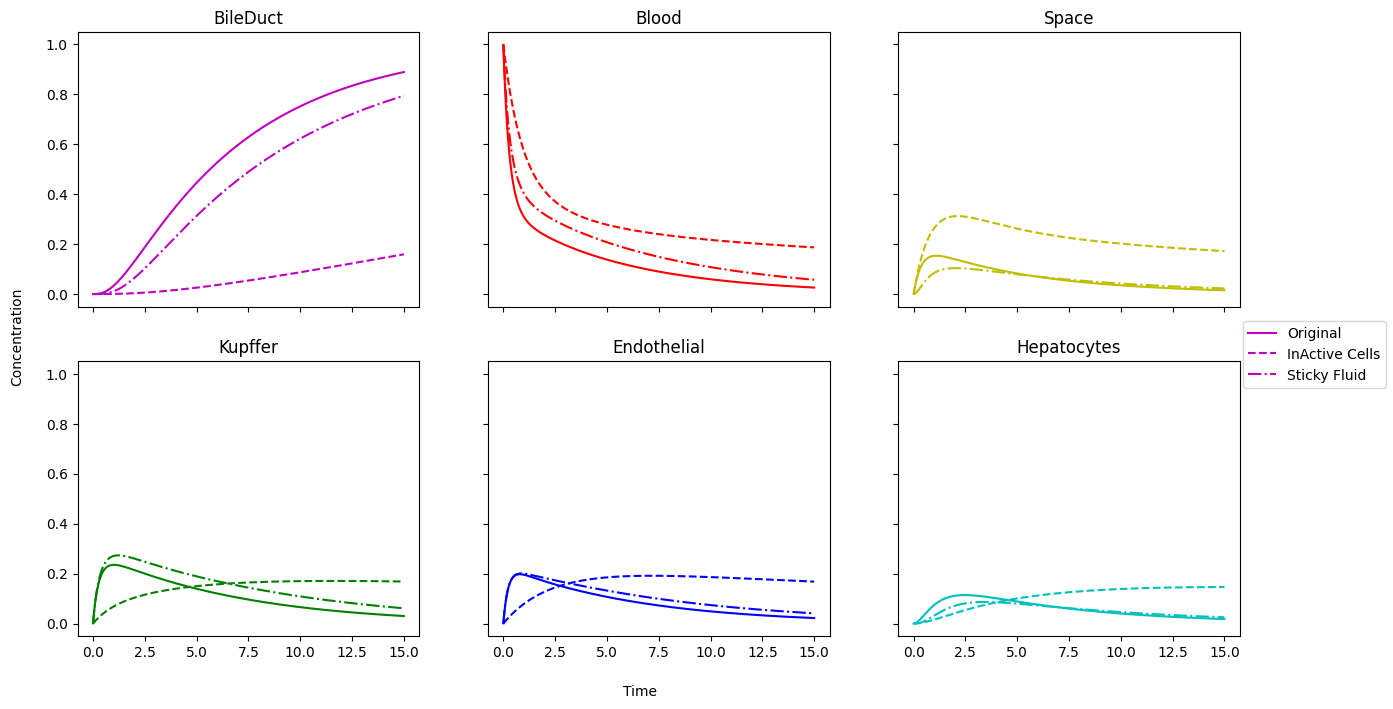

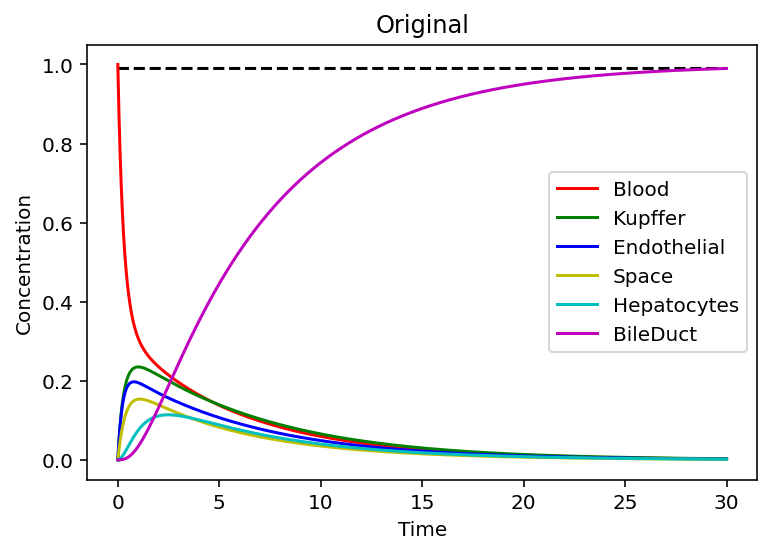

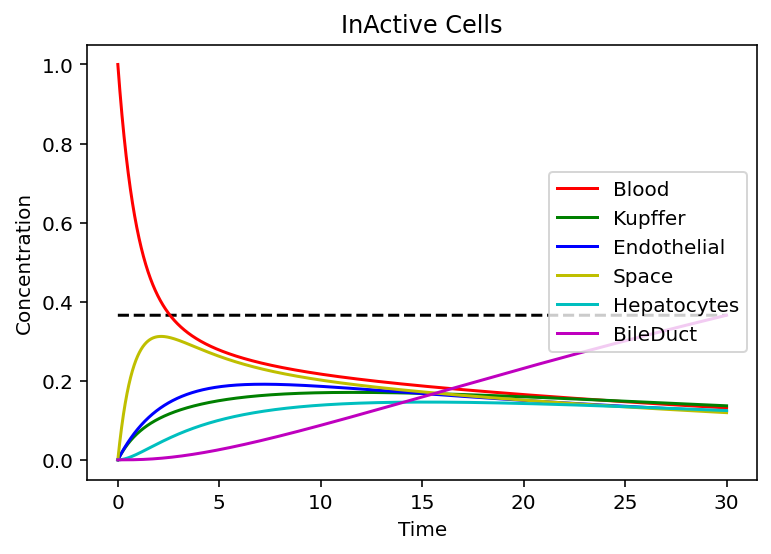

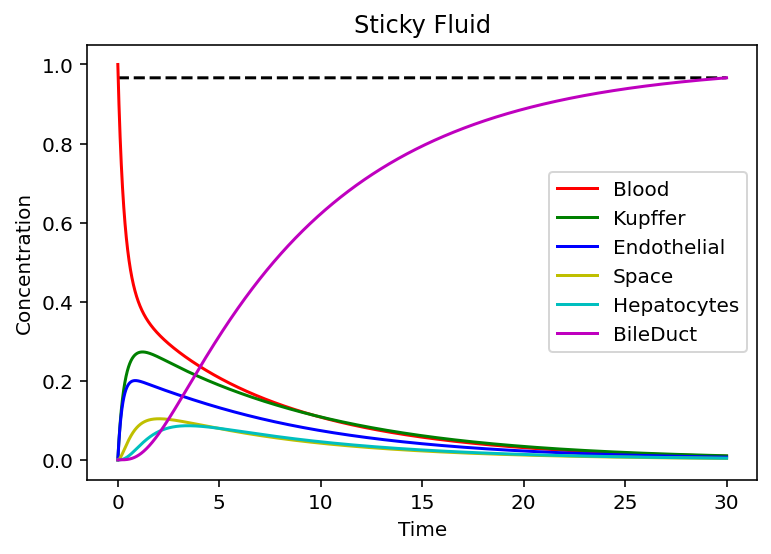

In [13]:
TARGET_TIME = 30

## With Body Fluid more Sticky
ode_Inactive_cell = Initialize_ODE(particle_data, fluid_data, cell_data)
ode_Inactive_cell.solve()

ode_list = [ode, ode_Inactive_cell, ode_Sticky_Fluid, ]
ode_names = ["Original", "InActive Cells", "Sticky Fluid"]
time_range = [0,15]
compare_ode_models(ode_list, ode_names, time_range)

If Cells are more likely in-active, which means they have lower rate_in and rate_out, most likely the whole process is been slowed down.
It can be seen that more particles will remain in cells if the fluid is "Sticky" or the Cells are inactive.
Therefore, there are significantly more particles in Space of Disse in "InActive Cell Model" as the fenestrae transmission is not affected.

